## **Quantum transport in presece of Rashba spin-orbit coupling**

Let us consider the following Hamiltonian
$$
\hat{H} = -\frac{\hbar^2}{2m} (\partial_x^2 + \partial_y^2) + i \tilde{\alpha} (\sigma_x \partial_y - \sigma_y \partial_x) + B_z  \sigma_z + V(x,y)\;.
$$
In the equation above, $\tilde{\alpha} = \alpha_R \mathcal{E}_z$, $\alpha_R$ being the naked Rashba SO coupling strength and $\mathcal{E}_z$ the electric field normal to the surface. Besides the standard Zeeman term, we set $V(x,y) = 0$.

In [7]:
# quantum processes with kwant
import kwant

# linear algebra support and  numpy
import numpy as np
import scipy.sparse.linalg as sla
import scipy.linalg as la

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc

# enable tex fonts
mpl.rcParams['text.usetex'] = True

In [2]:
# define the Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

###  **The Rashba SOC on a quantum billiard**

We deal with the same Hamiltonian, but now the shape of the scattering region is different.

In [3]:
def make_billiard_v1(a: float, Lmax: int, Wmax: float, alpha: float, Bz: float, lead_choice: str, plot_choice: str):

    # w proceed similarly to the square box case
    # defining a square lattice with constant 'a' and 2 orbitals per site (spin up vs. spin down)
    lat = kwant.lattice.square(a, norbs = 2)

    # hopping energy
    t = 1 / (2 * a**2)
    
    if plot_choice == 'yes': 
        print('Hopping energy [t] = ', t)

    # define here the shape of the scattering region  
    # the only argument is pos, which is a tuple of two elements
    def shape_billiard(pos):
        (x,y) = pos # we unpack the tuple
        x = max(np.abs(x) - Lmax, 0) # abs(x) - Lmax -> if negative x = 0. This creat a boundary at x = -Lmax and x = Lmax
        # now we check if the point is inside the circle
        return x**2 + y**2 < Wmax**2 
    
    system = kwant.Builder()

    # ******* define the scattering region *******
    # on-site energy
    system[lat.shape(shape_billiard, (0,0))] = 4 * t * sigma_0 + Bz * sigma_z
    # hopping along the x-direction
    system[kwant.builder.HoppingKind((1,0), lat, lat)] = - t * sigma_0 + 1j * alpha * sigma_y / (2*a)
    # hopping along the y-direction
    system[kwant.builder.HoppingKind((0,1), lat, lat)] = - t * sigma_0 - 1j * alpha * sigma_x / (2*a)

    # ******* define the leads *******
    if lead_choice == 'yes':
        lead_symmetry = kwant.TranslationalSymmetry((-a,0)) # we are attaching on the left and right but we can do things differently
        for start, end in [(-5,5)]: # lead goes from y = -5 to y = 5 at x = 0
            lead = kwant.Builder(lead_symmetry)
            lead[(lat(0,y) for y in range(start, end))] = 4 * t * sigma_0 + Bz * sigma_z
            lead[kwant.builder.HoppingKind((1,0), lat, lat)] = - t * sigma_0 + 1j * alpha * sigma_y / (2*a)
            lead[kwant.builder.HoppingKind((0,1), lat, lat)] = - t * sigma_0 - 1j * alpha * sigma_x / (2*a)
            system.attach_lead(lead)
            system.attach_lead(lead.reversed()) #it's easy to attach the second lead this way
    else:
        pass


    # ******* plot and finalize the system *******
    if plot_choice == 'yes':
        kwant.plot(system)
        
        # finalize the system
        system = system.finalized()

        # some internal checks - print number of nodes and hoppings
        num_nodes = system.graph.num_nodes
        print('Number of nodes: ', num_nodes)
        num_hops = system.graph.num_edges
        print('Number of hoppings: ', num_hops)   
    else:
        system = system.finalized()
   
    return system

Hopping energy [t] =  0.5


/tmp/ipykernel_190616/3961749276.py:47: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  kwant.plot(system)


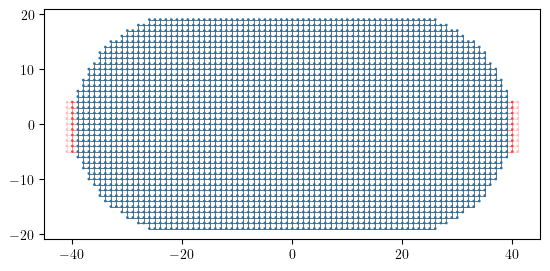

Number of nodes:  2805
Number of hoppings:  10984


In [4]:
ab = 1
Lmax = 20
Wmax = 20 
alpha = 0.25 
Bz = 0.05 

billiard = make_billiard_v1(ab, Lmax, Wmax, alpha, Bz, 'yes', 'yes')

Now, let's consider some output from the quantum billiards with RSOC we've just defined. We compute the conductance, as usual from the transmission matrix, by calling the s-matrix solver. Then we also consider the local density of states (LDOS) at a given energy. 

In [5]:
def conductance_energy_billiard(system, energies):

    data_conductance = []

    for energy in energies:
        # call the solver to compute the scattering matrix
        smatrix = kwant.smatrix(system, energy)
        # compute the transmission probability from lead 0 to lead 1
        trasmit = smatrix.transmission(1,0)
        data_conductance.append(trasmit)

    fig_cond, ax_cond = plt.subplots(1,1, figsize=(15,4))
    ax_cond.plot(energies, data_conductance)
    ax_cond.set_xlabel('Energy',fontsize=20)
    ax_cond.set_ylabel(r'$G$ [$e^2/h$]',fontsize=20)
    ax_cond.tick_params(axis='both', labelsize=15)
    ax_cond.grid(linestyle='--')

def dos_billiard(system, energy, spin_state: str):
    # call the solver - immediate
    local_dos = kwant.ldos(system, energy)
     
    # every site has 2 degrees of freedom (spin up vs. spin down)
    # kwant place degrees of freedom on the same site adjacent to one another
    # so we need to reshape
    local_dos = local_dos.reshape(-1,2)

    print(len(local_dos))
    # select the first column (one of the two spin components)
    local_dos_up = local_dos[:,0]

    # select the second column (the other spin component)
    local_dos_down = local_dos[:,1]

    # plot the local density of states
    if spin_state == 'up':
        kwant.plotter.map(system, local_dos_up, num_lead_cells=10, cmap='inferno', fig_size=(12,6))
        return local_dos_up
        #
        # for the other spin state
        #
    elif spin_state == 'down':
        kwant.plotter.map(system, local_dos_down, num_lead_cells=10, cmap='inferno', fig_size=(12,6))
        return local_dos_down
    else:
        print('Please select a valid spin state: up or down')
        return None
    

**Problem (SOLVED - KEEPING FOR REFERENCE)**: the local density of states returned by `dos_billiard` has exactly two time the number of sites in the system: the reason is that each site is accomodating for two orbitals.
So, we are in a situation where each site has the same number of degrees of freedom (`norbs = 2`); this situation is handled by kwant by putting degrees of freedom on the same site adjacent to one another. 


2805


/tmp/ipykernel_190616/538413705.py:37: RuntimeWarning: The plotted data contains 0.99% of values overflowing upper limit 0.393567 
  kwant.plotter.map(system, local_dos_up, num_lead_cells=10, cmap='inferno', fig_size=(12,6))


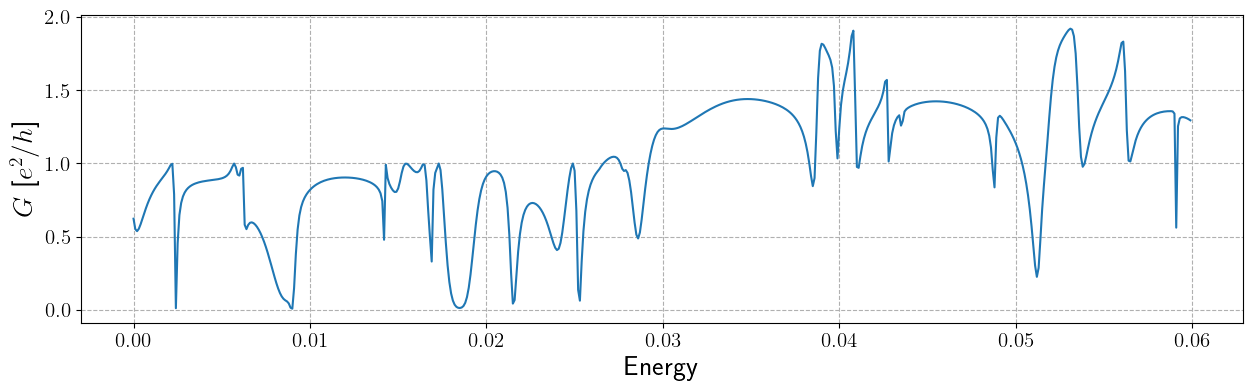

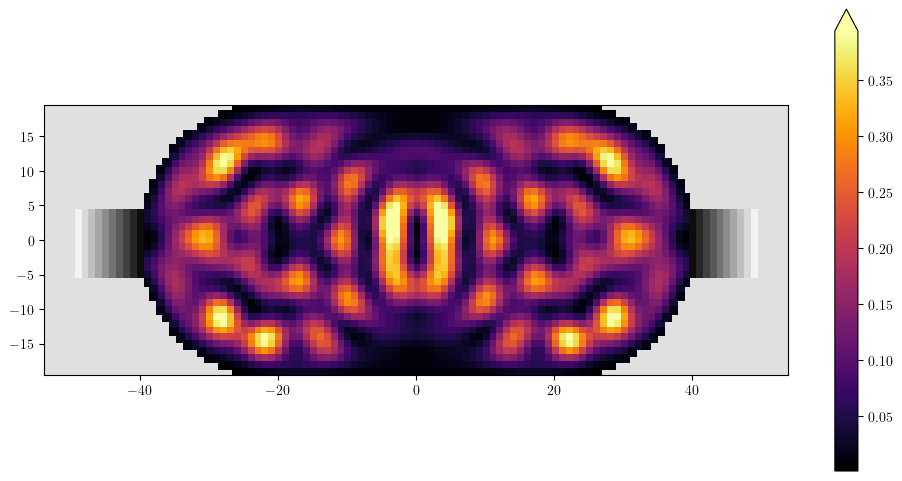

2805


/tmp/ipykernel_190616/538413705.py:43: RuntimeWarning: The plotted data contains 1.37% of values overflowing upper limit 1.08447 
  kwant.plotter.map(system, local_dos_down, num_lead_cells=10, cmap='inferno', fig_size=(12,6))


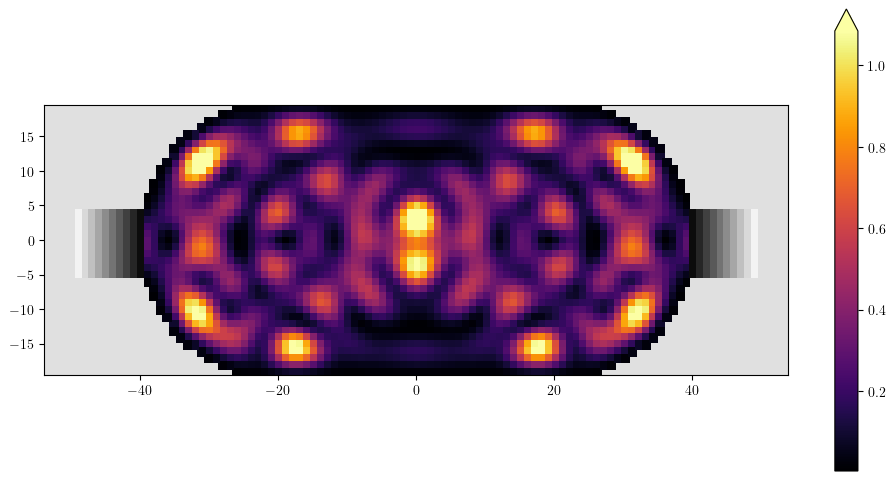

In [6]:
energies = [0. + 1e-4*i for i in range(600)]

conductance_energy_billiard(billiard, energies) #this can take time (\simeq 10 min) better choose the energies wisely

etry = 0.0

local_dos_up = dos_billiard(billiard, etry,'up')

local_dos_down = dos_billiard(billiard, etry,'down')


### **The closed system.** 

The routine we write below aims to analyze the billiard with RSOC with no attached leads, so a properly defined *closed system*. We want to extract the eigenvalues of $\hat{H}_{tot}$ and the corresponding eigenstates. We proceed as
1. We engineer the system by calling `make_billiard_v1`, passing `no` to `lead_choice` 
2. We extract the hamiltonian submatrix corresponding to the scattering region
3. Let's call a `scipy` routine to compute eigenvalues and eigenstates

**IMPORTANT REMARK.** Consider that the Rashba hamiltonian can be easily brought into momentum space (no dependence of the parameters on the position).

In [94]:
def closed_billiard(a: float, Lmax: int, Wmax: float, alpha: float, Bz: float, eigenplot: int):

    # define a system with no leads attached
    lead_choice = 'no'
    plot_choice = 'yes' # maybe we want to plot the system, if so change to yes

    system = make_billiard_v1(a, Lmax, Wmax, alpha, Bz, lead_choice, plot_choice) 

    # compute the Hamiltonian matrix
    ham_mat = system.hamiltonian_submatrix(sparse = True)

    # compute the lowest imax  eigenvalues
    # i'm calling the shift-invert mode (see scipy docs) ---> sigma specifies the target, 'LM' tells to find the largest eigenvalues (in magnitude) close to target
    # i have a feeling that the true eigenstates has energy a little bit below the scale set by Bz
    # if one moves sigma (i.e. targe) below we continue to find the same eigenvalues 
    imax = 15 # number of eigenvalues to compute
    
    # sort the eigenvalues --> lower energies first, so [0] is the ground state
    def sorted_eigs(ev):
        
        evals, evecs = ev
        evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
        return evals, evecs.transpose()

    # compute eigenvalues and eigenvectors via the shift-inverted method
    # TRICK: I'm telling the algorithm to look for eigenvalues close to -15 * Bz, since spectrum is bounded from below
    #        and it is the Zeeman term the one responsible for pushing up and down the bands ---> 
    #        PLEASE CHECK WHEN YOU WORK WITH THE CLOSED SYSTEM / CHANGE THE PARAMETERS 
    evals, evecs = sorted_eigs(sla.eigsh(ham_mat, k = imax, sigma = - 20 * Bz, which = 'LM', return_eigenvectors = True))

    for i in range(imax):
        print('Eigenvalue ', i, ' = ', evals[i])

    if eigenplot < imax and eigenplot >= 0:
        print('Plotted eigenmode ', eigenplot, ' with energy ', evals[eigenplot])
        # Plot the probability density of the  eigenmode.
        psi_sq = np.abs(evecs[:, eigenplot])**2
        psi_sq = psi_sq.reshape(-1,2)
        psi_sq_up = psi_sq[:,0]
        psi_sq_down = psi_sq[:,1]

        kwant.plotter.map(system, psi_sq_down, colorbar=True, oversampling=1, fig_size=(12,6))
        kwant.plotter.map(system, psi_sq_up, colorbar=True, oversampling=1, fig_size=(12,6))
    else:
        print('Please select a valid eigenmode to plot, between 0 and ', imax-1)

    return evals, evecs

Hopping energy [t] =  0.5


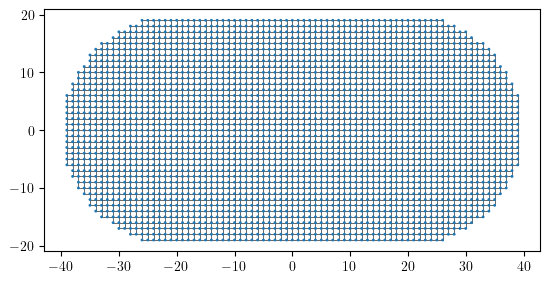

Number of nodes:  2805
Number of hoppings:  10984
Eigenvalue  0  =  -0.05076982771520744
Eigenvalue  1  =  -0.05073025168114964
Eigenvalue  2  =  -0.05050194562619448
Eigenvalue  3  =  -0.050015250140340806
Eigenvalue  4  =  -0.04983578304572234
Eigenvalue  5  =  -0.0495655297034443
Eigenvalue  6  =  -0.04884582523870895
Eigenvalue  7  =  -0.048704819524591714
Eigenvalue  8  =  -0.04745639647805833
Eigenvalue  9  =  -0.04659426146251744
Eigenvalue  10  =  -0.04593325412343363
Eigenvalue  11  =  -0.04524812258136124
Eigenvalue  12  =  -0.045167507364763604
Eigenvalue  13  =  -0.044145068865485304
Eigenvalue  14  =  -0.043109217356245955
Plotted eigenmode  0  with energy  -0.05076982771520744


/tmp/ipykernel_145675/1592679077.py:42: RuntimeWarning: The plotted data contains 0.43% of values overflowing upper limit 0.00206022 
  kwant.plotter.map(system, psi_sq_down, colorbar=True, oversampling=1, fig_size=(12,6))


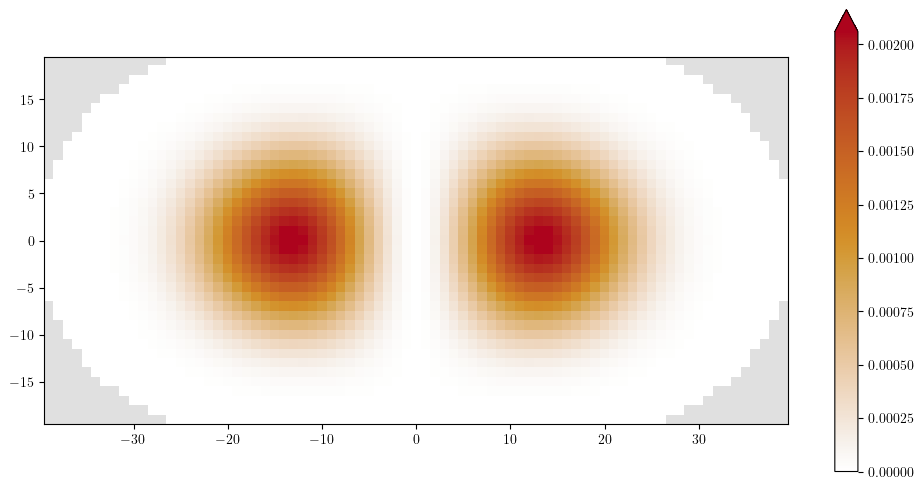

/tmp/ipykernel_145675/1592679077.py:43: RuntimeWarning: The plotted data contains 1.32% of values overflowing upper limit 0.000140883 
  kwant.plotter.map(system, psi_sq_up, colorbar=True, oversampling=1, fig_size=(12,6))


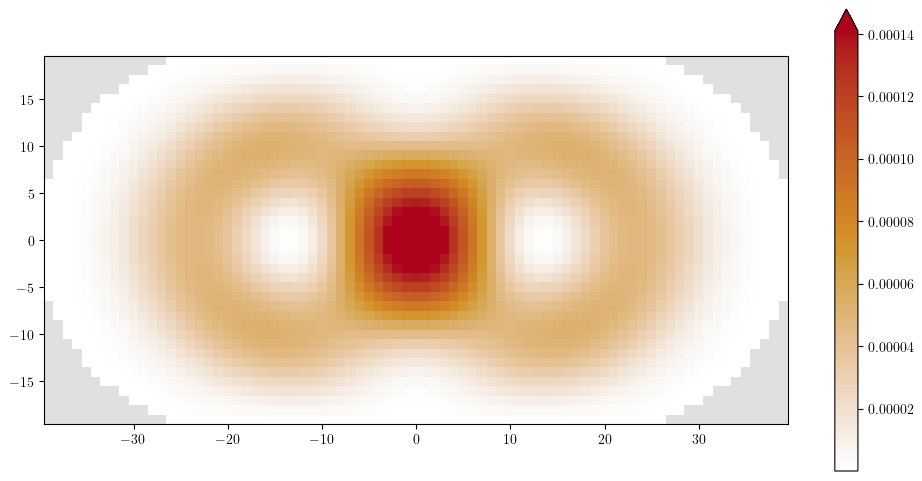

In [105]:
alpha = 0.25
Bz = 0.05

eigensystem = closed_billiard(ab, Lmax, Wmax, alpha, Bz, 0)

### **The closed system - Spectrum and control parameters.** 

We continue studying the closed billiard in presence of Rashba SOC. Now, we aim to investigate how changes in physical parameters such as the magnetic (Zeeman) field $B_z$ or the spin-orbit coupling strength $\alpha_R$ affect the spectrum of the system. Physically speaking, I would argue it is easier to control the SOC strength since the electric field can be reabsorbed in it, and an electric field is easier to tune.

**WORK IN PROGRESS.** I don't see anything interesting for now.

In [71]:
def billiard_spectrum_B(a: float, Lmax: int, Wmax: int, alpha_max: float, Bz_max: float, which_params: str):

    # some global scope variables
    lead_choice = 'no'
    plot_choice = 'no'

    # number of eigenvalues to compute
    imax = 15

    # sort the eigenvalues --> lower energies first, so [0] is the ground state
    def sorted_eigs(ev):
        
        evals, evecs = ev
        evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
        return evals, evecs.transpose()


    # which_params = 'Bz' or 'alpha'
    if which_params == 'Bz':
        
        Bz = np.linspace(0.01, Bz_max, 50)
        alpha = alpha_max
        
        # prepare an empty array where to store the eigenvalues
        evals_Bz = np.zeros((len(Bz), imax))

        # prepare the file to store the output 
        with open('billiard_spectrum_Bz.txt', 'w') as f:
            # compute the spectrum - consider the trick in calling the shift-inverted method, see above
            for i, Bz_i in enumerate(Bz):
                system = make_billiard_v1(a, Lmax, Wmax, alpha, Bz_i, lead_choice, plot_choice)
                ham_mat_run = system.hamiltonian_submatrix(sparse = True)
                evals_run, evecs_run = sorted_eigs(sla.eigsh(ham_mat_run, k = imax, sigma = - 20 * Bz_i, which = 'LM', return_eigenvectors = True))
                evals_Bz[i,:] = evals_run
                # save Bz_i and evals_run to file 
                f.write(str(Bz_i) + ' ' + ' '.join(map(str, evals_run)) + '\n')

            return Bz, evals_Bz
    
    elif which_params == 'alpha':

        alpha = np.linspace(0.01, alpha_max, 50)
        Bz = Bz_max

        # prepare an empty array where to store the eigenvalues
        evals_alpha = np.zeros((len(alpha), imax))

        # prepare the file to store the output
        with open('billiard_spectrum_alpha.txt', 'w') as f:
        # compute the spectrum - consider the trick in calling the shift-inverted method, see above
            for i, alpha_i in enumerate(alpha):
                system = make_billiard_v1(a, Lmax, Wmax, alpha_i, Bz, lead_choice, plot_choice)
                ham_mat_run = system.hamiltonian_submatrix(sparse = True)
                evals_run, evecs_run = sorted_eigs(sla.eigsh(ham_mat_run, k = imax, sigma = - 20 * Bz, which = 'LM', return_eigenvectors = True))
                evals_alpha[i,:] = evals_run
                # save alpha_i and evals_run to file
                f.write(str(alpha_i) + ' ' + ' '.join(map(str, evals_run)) + '\n')

            return alpha, evals_alpha

    else:
        print('Please select a valid parameter to vary: Bz or alpha')

In [72]:
Bz = 0.5
alpha = 0.5

magnetic_fields, spectrum_B = billiard_spectrum_B(ab, Lmax, Wmax, alpha, Bz, 'Bz')
#soc_strength, spectrum_soc = billiard_spectrum_B(ab, Lmax, Wmax, alpha, Bz, 'alpha')

In [ ]:
data = np.loadtxt('billiard_spectrum_Bz.txt')

# Separate the data into x values (Bz) and y values (eigenvalues)
control_parameter = data[:, 0]
eigenvalues_output = data[:, 1:]

# Plot the eigenvalues as a function of Bz
for i in range(eigenvalues_output.shape[1]):
    plt.plot(control_parameter, eigenvalues_output[:, i])

plt.xlabel(r'$B_z$ $\mathrm{[a.u]}$',fontsize=20)
plt.ylabel(r'$\mathrm{Energy}$ $\mathrm{[a.u]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.grid(linestyle='--')
plt.title(r'$\alpha = $' + str(alpha), fontsize=20)
#plt.xlim(0.7, 0.7525)
#plt.ylim(-0.505, -0.495)
plt.show()